### Подключение библиотек и скриптов.

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# import warnings
# warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    plt.show()

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Загрузка данных.
#### Описание датасета:
* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [6]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [7]:
train_data = pd.read_csv(TRAIN_DATASET_PATH)
train_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [8]:
test_data = pd.read_csv(TEST_DATASET_PATH)
test_data.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


### Уменьшение объема памяти, который занимает датасет.

In [9]:
train_data.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [10]:
train_data = reduce_mem_usage(train_data)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


### Приведение типов.

In [11]:
train_data['Id'] = train_data['Id'].astype(str)
train_data['DistrictId'] = train_data['DistrictId'].astype(str)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  object  
 1   DistrictId     10000 non-null  object  
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

### Обзор целевой переменной.

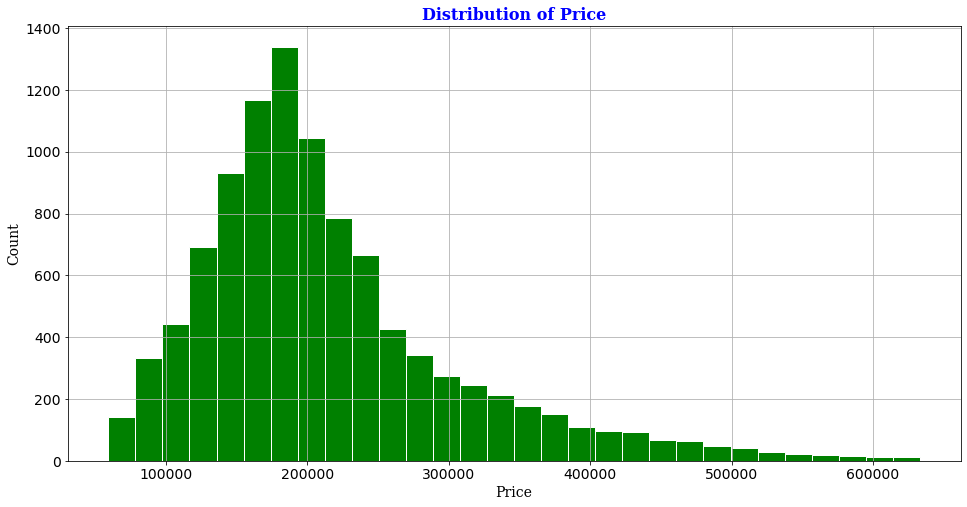

In [12]:
plt.figure(figsize = (16, 8))
label_font = {
    "fontsize": 14,
    "family": "serif",
}
title_font = {
    "fontsize": 16,
    "fontweight": "bold",
    "color": "blue",
    "family": "serif"
}
train_data['Price'].hist(density=False, bins=30, color="green", ec="white")
plt.ylabel('Count', fontdict=label_font)
plt.xlabel('Price', fontdict=label_font)

plt.title('Distribution of Price', fontdict=title_font)
plt.show()

#### Нахождение среднего значения, медианы и моды целевой переменной.

In [13]:
target_mean = round(train_data['Price'].mean(), 2)
target_median = train_data['Price'].median()
target_mode = train_data['Price'].mode()[0]

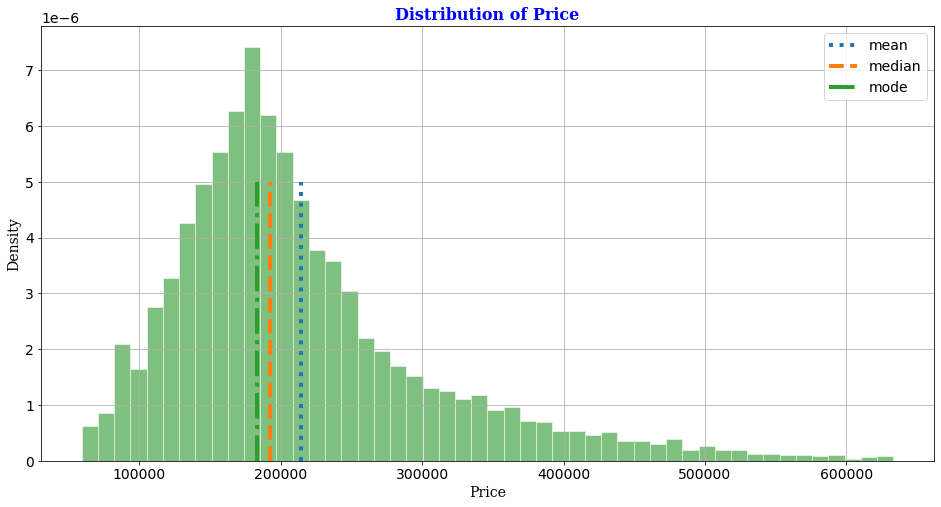

In [14]:
plt.figure(figsize = (16, 8))

train_data['Price'].hist(density=True, bins=50, color="green", ec="white", alpha = 0.5)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of Price', fontdict=title_font)
plt.ylabel('Density', fontdict=label_font)
plt.xlabel('Price', fontdict=label_font)
plt.legend()
plt.show()

### Обзор количественных переменных.

In [15]:
train_data_num_features = train_data.select_dtypes(include=['float32', 'int16', 'int32', 'int8'])
train_data_num_features.drop('Price', axis=1, inplace=True)

C:\Users\ivina\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [16]:
train_data_num_features

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,11,3097,0,NaN,0,0
1,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0
2,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1
3,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1
4,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,33,8667,2,NaN,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,52,10311,6,NaN,1,9
9996,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,2,629,1,NaN,0,0
9997,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,20,4386,14,NaN,1,5
9998,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,47,8004,3,125.0,3,5


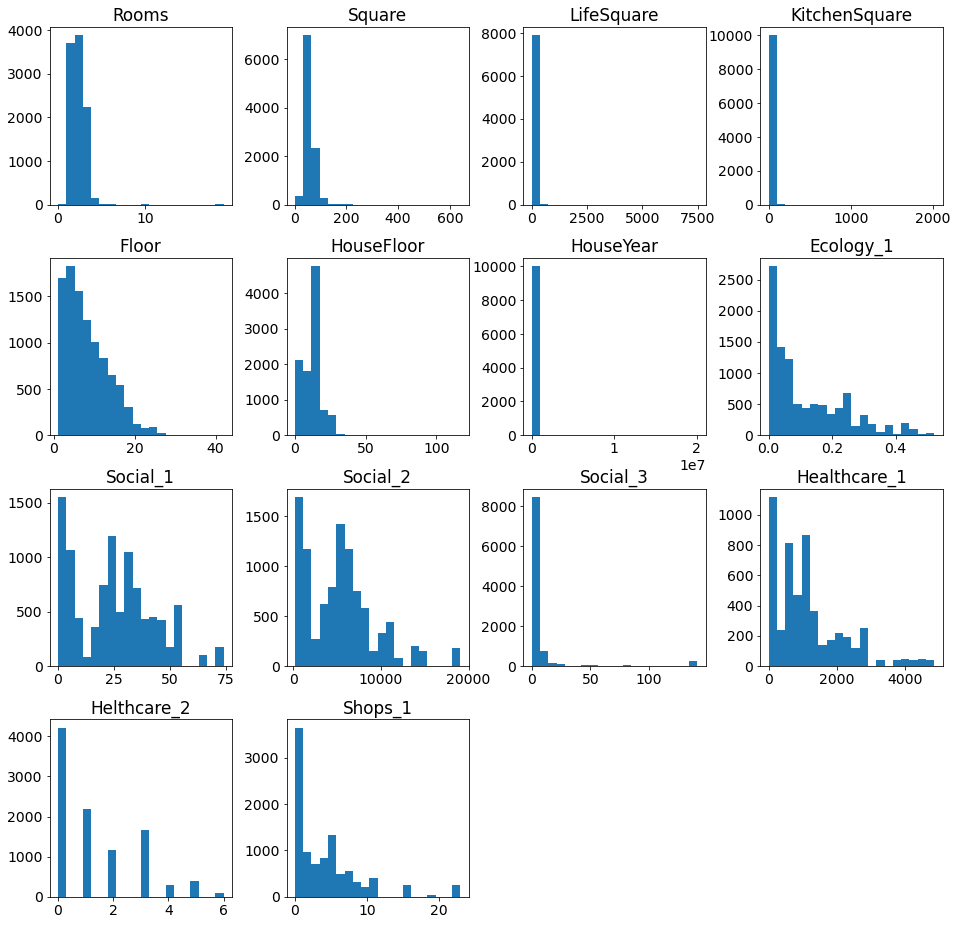

In [17]:
train_data_num_features.hist(figsize=(16,16), bins=20, grid=False);
#Заметно наличие выбросов в количестве комнат, площадях квартир, годах постройки дома.

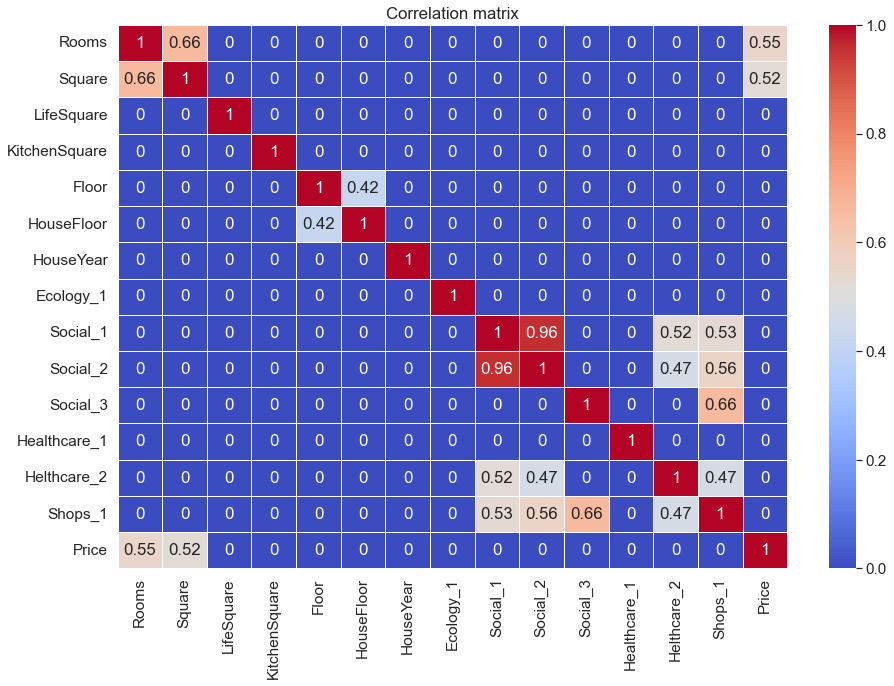

In [18]:
#Создание матрицы корреляций для оценки линейных связей между переменными.
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train_data.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [19]:
#Целевая переменная сильно зависит от количества комнат и площади.

C:\Users\ivina\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


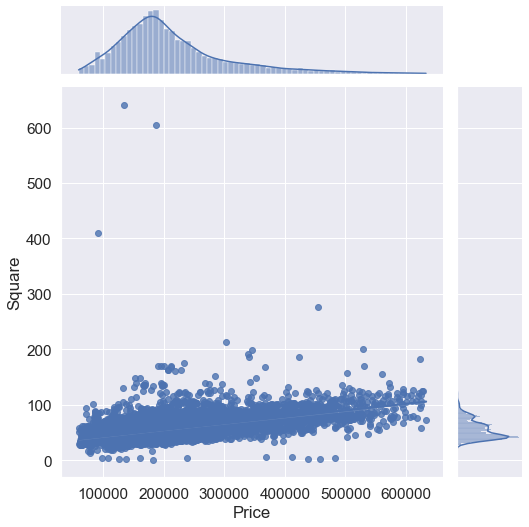

In [20]:
grid = sns.jointplot(train_data['Price'], train_data['Square'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

In [21]:
train_data.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


### Заполнение пропусков.

In [22]:
train_data=train_data.sort_values(by='Square')
train_data['LifeSquare'].fillna(method='pad',inplace=True)

In [23]:
train_data=train_data.sort_values(by='DistrictId')
train_data['Healthcare_1'].fillna(method='pad',inplace=True)


In [24]:
train_data.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

### Обзор номинативных переменных.

In [25]:
train_data_obj = train_data.select_dtypes(include=('object', 'category'))

train_data_obj.head()

,Id,DistrictId,Ecology_2,Ecology_3,Shops_2
854,11426,0,B,B,B
3371,15898,0,B,B,B
1621,7586,0,B,B,B
6107,3789,0,B,B,B
4637,3808,0,B,B,B


In [26]:
print(train_data['DistrictId'].value_counts())
print(train_data['Ecology_2'].value_counts())
print(train_data['Ecology_3'].value_counts())
print(train_data['Shops_2'].value_counts())

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
117      1
209      1
174      1
199      1
Name: DistrictId, Length: 205, dtype: int64
B    9903
A      97
Name: Ecology_2, dtype: int64
B    9725
A     275
Name: Ecology_3, dtype: int64
B    9175
A     825
Name: Shops_2, dtype: int64


In [27]:
#Переведем категориальные переменные в бинарные.

columns_obj = train_data.select_dtypes('category').columns
train_data = pd.get_dummies(train_data, columns=columns_obj)

In [28]:
train_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
854,11426,0,2.0,56.724377,32.602234,8.0,9,12.0,1982,0.006076,...,645.0,6,6,164687.828125,0,1,0,1,0,1
3371,15898,0,2.0,51.430744,28.627539,9.0,4,12.0,1978,0.319809,...,2857.0,5,8,246620.765625,0,1,0,1,0,1
1621,7586,0,2.0,45.662270,30.086910,6.0,4,5.0,1959,0.319809,...,2857.0,5,8,221660.250000,0,1,0,1,0,1
6107,3789,0,1.0,36.765160,22.094906,5.0,10,9.0,1964,0.319809,...,2857.0,5,8,155874.890625,0,1,0,1,0,1
4637,3808,0,3.0,76.585037,52.310863,8.0,4,8.0,1960,0.319809,...,2857.0,5,8,339228.812500,0,1,0,1,0,1


### Обработка выбросов.

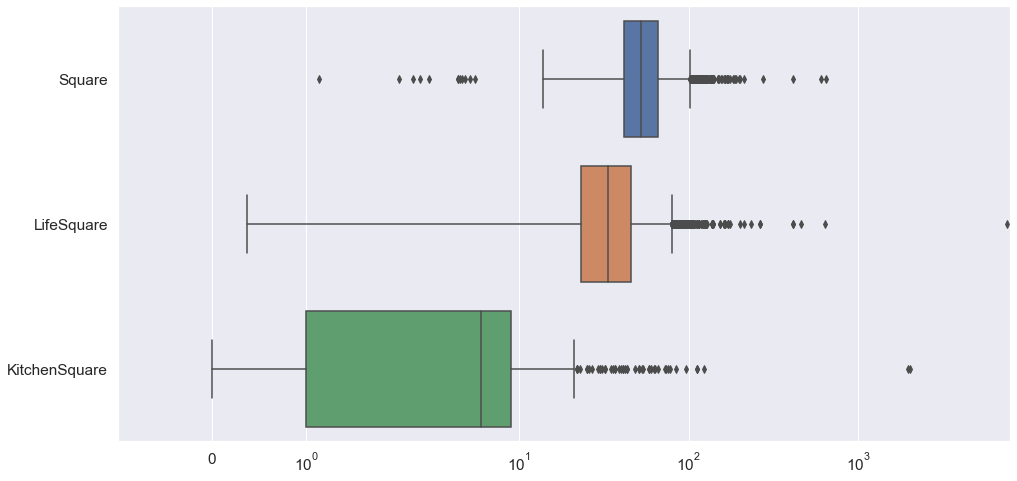

In [29]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=train_data[['Square', 'LifeSquare', 'KitchenSquare']], orient='h')
plt.xscale('symlog')
plt.xlim(left=-1)
plt.show()

#### Ввод дополнительного признака (цена за кв.м).

In [30]:
train_data['SqMeterPrice']= train_data['Price']/train_data['Square']

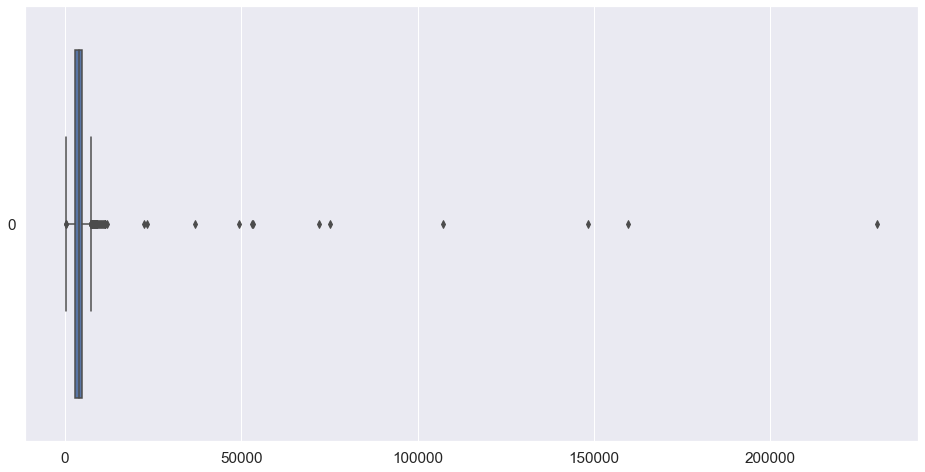

In [31]:
#Посмотрим на выбросы по новому признаку:
plt.figure(figsize=(16, 8))
sns.boxplot(data=train_data['SqMeterPrice'], orient='h')
plt.show()

#### Square. LifeSquare. KitchenSquare.

In [32]:
train_data.sort_values(by='Square', axis=0, ascending=True).head()                                                           

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,SqMeterPrice
7470,14786,1,1.0,1.136859,4.525736,1.0,3,1.0,1977,0.007122,...,0,1,181434.828125,0,1,0,1,0,1,159593.109375
4496,15744,34,1.0,1.988943,2.642219,1.0,21,4.0,1977,0.069753,...,1,11,458378.781250,0,1,0,1,0,1,230463.531250
9869,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,...,0,0,126596.945312,0,1,0,1,0,1,53253.582031
8572,10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,...,0,0,137597.593750,0,1,0,1,0,1,52996.527344
161,6782,45,1.0,2.954309,5.257278,1.0,3,1.0,1977,0.195781,...,3,2,438005.187500,0,1,0,1,0,1,148259.796875


In [33]:
train_data.loc[train_data['Square'] < 15, 'Square'] = 15
train_data.loc[train_data['LifeSquare'] < 10, 'LifeSquare'] = 10
train_data.loc[train_data['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [34]:
train_data['SqMeterPrice']= train_data['Price']/train_data['Square']

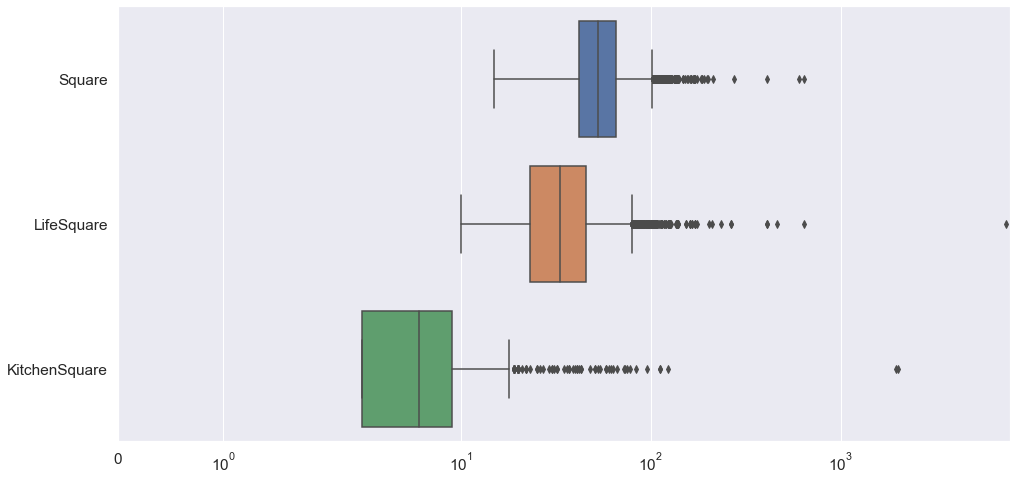

In [35]:
#Снова посмотрим на выбросы по площадям и по цене за кв.м:
plt.figure(figsize=(16, 8))
sns.boxplot(data=train_data[['Square', 'LifeSquare', 'KitchenSquare']], orient='h')
plt.xscale('symlog')
plt.xlim(left=0)
plt.show()

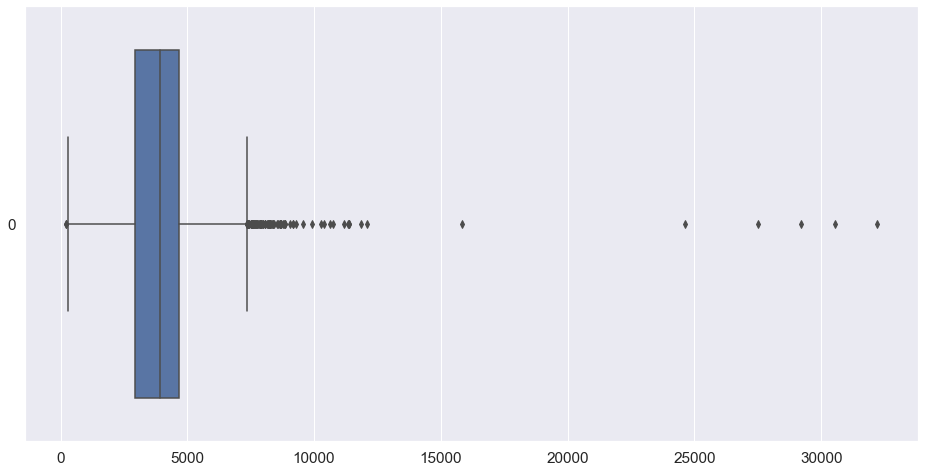

In [36]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=train_data['SqMeterPrice'], orient='h')
plt.show()

#### Rooms.

In [37]:
train_data['Rooms'].unique()

array([ 2.,  1.,  3., 19.,  4.,  5.,  0., 10.,  6.], dtype=float32)

In [38]:
train_data[train_data['Rooms']>6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,SqMeterPrice
6088,8491,1,19.0,42.006046,21.779287,7.0,17,17.0,2014,0.007122,...,0,1,78364.617188,0,1,0,1,0,1,1865.555664
2004,5927,57,10.0,59.056976,36.223072,10.0,22,22.0,2002,0.090799,...,5,15,317265.312500,0,1,0,1,0,1,5372.190430
2728,14865,9,10.0,60.871265,38.420681,10.0,3,2.0,1994,0.161532,...,2,4,172329.265625,0,1,0,1,0,1,2831.044678


In [39]:
train_data[train_data['Rooms']==0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,SqMeterPrice
9869,3224,27,0.0,15.000000,10.000000,3.0,1,0.0,1977,0.017647,...,0,0,126596.945312,0,1,0,1,0,1,8439.795898
7644,7917,27,0.0,212.932358,211.231125,3.0,2,3.0,2008,0.211401,...,0,1,302211.250000,0,1,0,1,0,1,1419.282837
9767,12638,27,0.0,138.427689,136.215500,3.0,4,3.0,2016,0.075424,...,0,0,268394.750000,0,1,0,1,0,1,1938.880493
6401,9443,27,0.0,87.762619,85.125473,3.0,5,15.0,1977,0.211401,...,0,1,219281.921875,0,1,0,1,0,1,2498.580078
3780,7317,27,0.0,41.790882,24.488808,3.0,13,0.0,1977,0.211401,...,0,1,98129.976562,0,1,0,1,0,1,2348.119385
5894,770,28,0.0,49.483501,30.057049,3.0,16,0.0,2015,0.118537,...,1,0,217009.343750,0,1,0,1,0,1,4385.488770
7929,456,6,0.0,81.491447,76.646179,3.0,4,0.0,1977,0.243205,...,0,0,212864.796875,0,1,0,1,0,1,2612.112061
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,...,3,9,158998.109375,0,1,0,1,0,1,4108.784180


In [40]:
# Заменим некорректные значения на медиану.
train_data.loc[((train_data['Rooms'] > 6)|(train_data['Rooms'] == 0)), 'Rooms'] = train_data['Rooms'].median()

#### HouseFloor. Floor.

In [41]:
train_data['HouseFloor'].unique()

array([ 12.,   5.,   9.,   8.,  10.,  22.,  17.,  19.,  21.,  16.,  15.,
        14.,   1.,  24.,  25.,  20.,   0.,   3.,  18.,   7.,   4.,   6.,
        11.,   2.,  28.,  13.,  30.,  23.,  38.,  37.,  32.,  27.,  47.,
        48.,  29.,  39., 117.,  44.,  40.,  26.,  99.,  31.,  36.,  45.],
      dtype=float32)

In [42]:
train_data.loc[(train_data['HouseFloor'] == 0), 'HouseFloor'] = train_data['HouseFloor'].median()
floor_outliers = train_data.loc[train_data['Floor'] > train_data['HouseFloor']].index

In [43]:
train_data.loc[floor_outliers, 'Floor'] = train_data.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [44]:
(train_data['Floor'] > train_data['HouseFloor']).sum()

0

#### House Year.

In [45]:
train_data.sort_values(by='HouseYear', axis=0, ascending=False).head() 

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,SqMeterPrice
9163,10814,109,1.0,37.265072,20.239714,9.0,9,12.0,20052011,0.136330,...,3,6,254084.531250,0,1,0,1,0,1,6818.302246
8828,11607,147,2.0,44.791836,28.360394,5.0,4,9.0,4968,0.319809,...,5,8,243028.609375,0,1,0,1,0,1,5425.734375
7302,12191,74,1.0,42.799881,19.819576,13.0,1,1.0,2020,0.075779,...,0,2,162260.687500,0,1,0,1,0,1,3791.148193
7721,8892,62,1.0,49.298504,51.135513,9.0,9,12.0,2020,0.072158,...,0,0,151779.187500,0,1,0,1,1,0,3078.778809
9091,3511,59,1.0,48.327499,48.028008,3.0,3,10.0,2020,0.019509,...,5,5,227402.468750,0,1,0,1,0,1,4705.446777


In [46]:
train_data.loc[train_data['HouseYear'].isin([4968]), 'HouseYear'] = 1968
train_data.loc[train_data['HouseYear'].isin([20052011]), 'HouseYear'] = 2005

In [47]:
train_data.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,SqMeterPrice
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,56.329319,38.022667,6.974800,7.387900,12.959100,1984.865700,0.118858,24.687000,5352.157400,...,1.319500,4.231300,214138.593750,0.009700,0.990300,0.027500,0.972500,0.082500,0.917500,3906.701660
std,0.812108,21.028151,77.150116,28.443481,5.033286,6.443588,18.411517,0.119027,17.532614,4006.799803,...,1.493601,4.806341,92872.101562,0.098015,0.098015,0.163543,0.163543,0.275139,0.275139,1380.259277
min,1.000000,15.000000,10.000000,3.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,...,0.000000,0.000000,59174.777344,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,208.293457
25%,1.000000,41.774879,23.178716,3.000000,3.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,...,0.000000,1.000000,153872.628906,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,2918.525391
50%,2.000000,52.513309,33.353085,6.000000,6.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,...,1.000000,3.000000,192269.648438,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,3910.052246
75%,2.000000,65.900627,45.748028,9.000000,10.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,...,2.000000,6.000000,249135.460938,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,4692.375977
max,6.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,...,6.000000,23.000000,633233.437500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,32218.900391


In [48]:
class FeaturesGenerator():
    
    def __init__(self):
        
        self.cat_columns=None
        
        
    def transform(self,df):
        
        # Корректируем значения площадей, и количество комнат
        
        df.loc[df['Square'] < 15, 'Square'] = 15
        df.loc[df['LifeSquare'] < 10, 'LifeSquare'] = 10
        df.loc[df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        df.loc[((df['Rooms'] > 6)|(df['Rooms'] == 0)), 'Rooms'] = df['Rooms'].median()
               
              
        # Корректируем значения этажей
        
        df.loc[(df['HouseFloor'] == 0), 'HouseFloor'] = df['HouseFloor'].median()
        floor_outliers = df.loc[df['Floor'] > df['HouseFloor']].index
        df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))
        
        # Назначаем столбцы для последующего дамми-кодирования. Кодируем категориальные переменные
        
        self.cat_columns=df.select_dtypes('category').columns
        df=pd.get_dummies(df, columns=self.cat_columns)
        
        
        # Заменяем год постройки дома 
        df.loc[df['HouseYear'] > 2020, 'HouseYear'] = 2020
         
                
        # Обрабатываем пропуски полях Healthcare_1 и LifeSquare, заполняя их методом 'pad'
        
        df=df.sort_values(by='Square')
        df['LifeSquare'].fillna(method='pad',inplace=True)
        df=df.sort_values(by='DistrictId')
        df['Healthcare_1'].fillna(method='pad',inplace=True)
        df.sort_index(inplace=True)
        
        
        # Переводим DistrictId, и Id в нечисловые признаки
        
        df['DistrictId']=df['DistrictId'].astype('object')
        df['Id']=df['Id'].astype('object')
        
        return df

### Построение модели.

In [49]:
X = train_data.drop(['Id', 'DistrictId', 'Price'], axis=1)
y = train_data['Price']

In [50]:
test_data = reduce_mem_usage(test_data)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


In [51]:
generator = FeaturesGenerator()
test_data = generator.transform(test_data)

In [52]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   object 
 1   DistrictId     5000 non-null   object 
 2   Rooms          5000 non-null   float32
 3   Square         5000 non-null   float32
 4   LifeSquare     5000 non-null   float32
 5   KitchenSquare  5000 non-null   float32
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float32
 8   HouseYear      5000 non-null   int16  
 9   Ecology_1      5000 non-null   float32
 10  Social_1       5000 non-null   int8   
 11  Social_2       5000 non-null   int16  
 12  Social_3       5000 non-null   int16  
 13  Healthcare_1   5000 non-null   float32
 14  Helthcare_2    5000 non-null   int8   
 15  Shops_1        5000 non-null   int8   
 16  Ecology_2_A    5000 non-null   uint8  
 17  Ecology_2_B    5000 non-null   uint8  
 18  Ecology_

In [53]:
test_idx = test_data.pop('Id')

#### Разбиение на train и test


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

#### Обучение

In [55]:
rf_model = RandomForestRegressor(random_state=21, bootstrap = False, max_features = 'log2', min_samples_split = 8, n_estimators = 30)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_features='log2', min_samples_split=8,
                      n_estimators=30, random_state=21)

#### Оценка модели

Train R2:	0.993
Test R2:	0.951


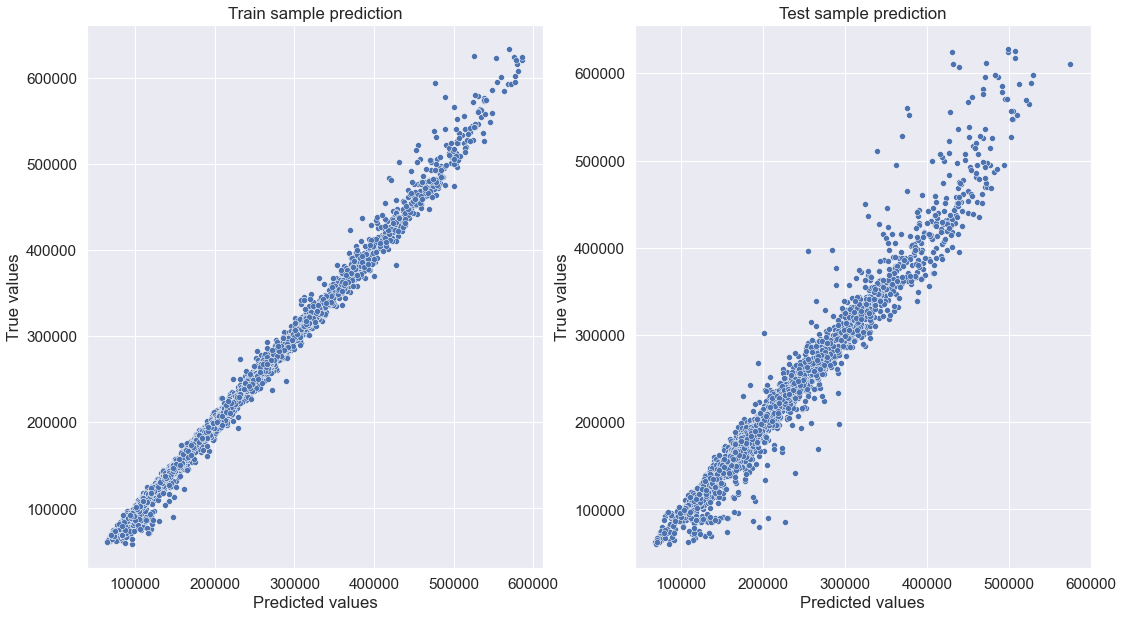

In [56]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

#### Важность признаков

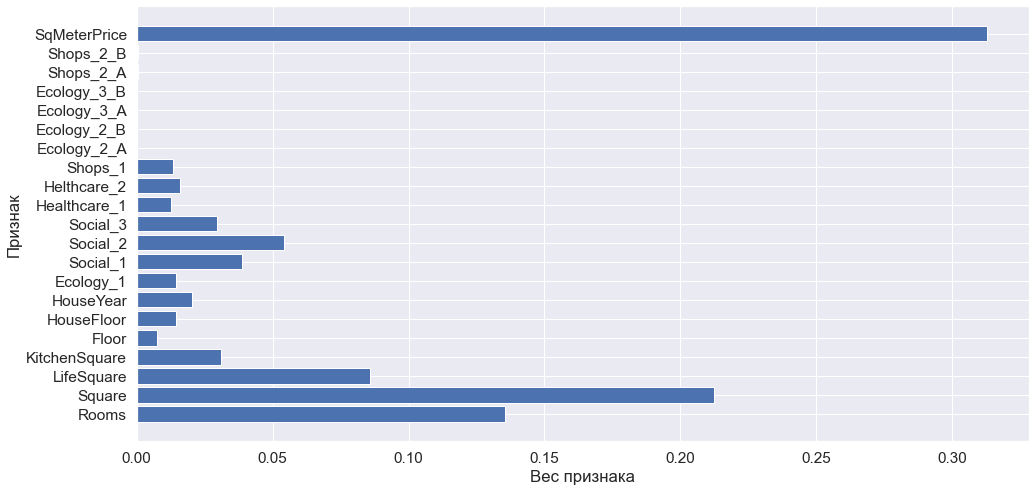

In [57]:
plt.figure(figsize=(16,8))
plt.barh(X_train.columns.tolist(), rf_model.feature_importances_)
plt.xlabel('Вес признака')
plt.ylabel('Признак')
plt.show()

In [58]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
20,SqMeterPrice,0.312689
1,Square,0.212252
0,Rooms,0.135387
2,LifeSquare,0.085658
9,Social_2,0.054261
8,Social_1,0.038833
3,KitchenSquare,0.030992
10,Social_3,0.029449
6,HouseYear,0.020349
12,Helthcare_2,0.015990


#### Перекрестная проверка.

In [59]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.95572013, 0.95117946, 0.94235961])

In [60]:
cv_score.mean()

0.9497530644182243

#### Прогнозирование на тестовом датасете

In [61]:
predictions = rf_model.predict(test_data)
predictions

array([163840.15531498, 182352.84083643, 198867.72790179, ...,
       146799.40408544, 164097.0727629 , 185930.57696243])

In [62]:
result=pd.DataFrame({'Id':test_idx, 'Price':predictions})
result.head()

,Id,Price
0,4567,163840.155315
1,5925,182352.840836
2,960,198867.727902
3,3848,182639.476590
4,746,182816.978999


In [63]:
result.to_csv('A_Ivina_predictions.csv',  sep=',', index=False)